In [1]:
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def load_and_resize_images_from_subfolders(folder, target_shape):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            resized_img = cv2.resize(img, target_shape)  # Resize to target shape
            images.append(resized_img)
    return images

# Define target shape for images
target_shape = (224, 224)

# Load and resize resume images
resume_images = load_and_resize_images_from_subfolders("C:/Users/atulp/Downloads/Dataset Resume/Resumes", target_shape)

# Load and resize non-resume images
non_resume_images = load_and_resize_images_from_subfolders("C:/Users/atulp/Downloads/Dataset Resume/Non-Resumes", target_shape)


In [2]:
# Convert to NumPy arrays
resume_array = np.array(resume_images)
non_resume_array = np.array(non_resume_images)


In [3]:
# Create labels for the image data
resume_labels = np.ones(len(resume_array))  # Set label 1 for resumes
non_resume_labels = np.zeros(len(non_resume_array))  # Set label 0 for non-resumes


In [4]:
# Merge data and labels
labeled_resume_data = list(zip(resume_array, resume_labels))
labeled_non_resume_data = list(zip(non_resume_array, non_resume_labels))

In [5]:
# Concatenate labeled data
labeled_data = labeled_resume_data + labeled_non_resume_data

In [6]:
# Shuffle the data
np.random.shuffle(labeled_data)

In [8]:
# Separate images and labels
images, labels = zip(*labeled_data)

In [9]:
# Convert to numpy arrays
images_array = np.array(images)
labels_array = np.array(labels)

In [10]:
# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images_array, labels_array, test_size=0.2, random_state=42)

In [11]:
# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
val_images = val_images / 255.0


In [12]:
# Augmenting training images
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    rescale=1./255,
)

In [13]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Validation data shouldn't be augmented

In [14]:
batch_size = 32
# Fit the data generators
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)


In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load DenseNet121 model with pre-trained weights, excluding top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)  # Change '2' to the number of your classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers of the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Implement EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/25
4/4 [==============================] - 15s 2s/step - loss: 0.9178 - accuracy: 0.4906 - val_loss: 0.8675 - val_accuracy: 0.3333
Epoch 2/25
4/4 [==============================] - 8s 2s/step - loss: 0.7817 - accuracy: 0.5283 - val_loss: 0.8281 - val_accuracy: 0.3333
Epoch 3/25
4/4 [==============================] - 7s 2s/step - loss: 0.7725 - accuracy: 0.5755 - val_loss: 0.7668 - val_accuracy: 0.3333
Epoch 4/25
4/4 [==============================] - 7s 2s/step - loss: 0.7535 - accuracy: 0.5566 - val_loss: 0.7300 - val_accuracy: 0.3333
Epoch 5/25
4/4 [==============================] - 7s 2s/step - loss: 0.7040 - accuracy: 0.6038 - val_loss: 0.7169 - val_accuracy: 0.3333
Epoch 6/25
4/4 [==============================] - 7s 2s/step - loss: 0.7954 - accuracy: 0.6132 - val_loss: 0.6879 - val_accuracy: 0.6667
Epoch 7/25
4/4 [==============================] - 7s 2s/step - loss: 0.8194 - accuracy: 0.5283 - val_loss: 0.6580 - val_accuracy: 0.6667
Epoch 8/25
4/4 [========================

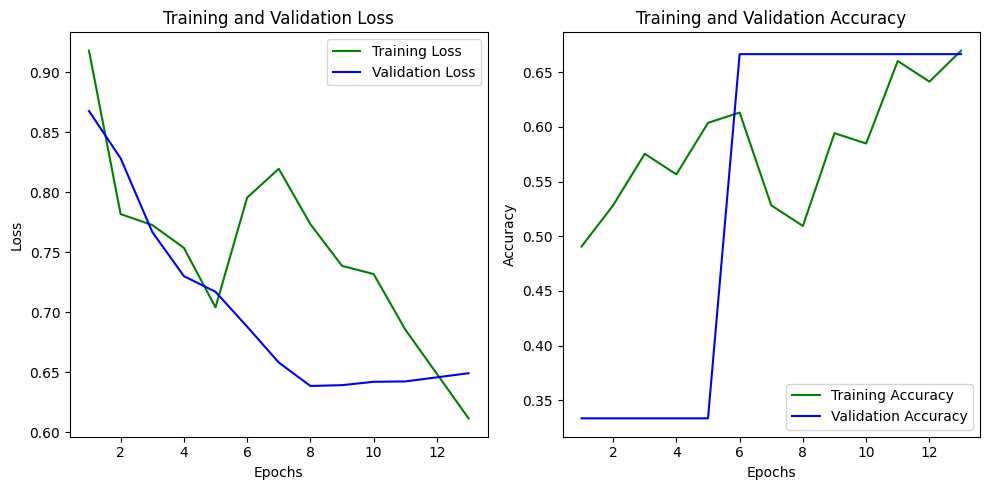

In [16]:
import matplotlib.pyplot as plt

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Function to load and preprocess images from subfolders
def load_and_load_images_from_subfolders(root_folder_path, target_shape):
    images = []
    labels = []
    classes = ["Resumes", "Non-Resumes"]  # Folder names for classes

    for class_idx, class_name in enumerate(classes):
        class_folder_path = os.path.join(root_folder_path, class_name)
        for filename in os.listdir(class_folder_path):
            img = cv2.imread(os.path.join(class_folder_path, filename))
            if img is not None:
                # Preprocess your image (resize, normalize, etc.)
                resized_img = cv2.resize(img, target_shape)  # Resize to target shape
                normalized_img = resized_img / 255.0  # Normalize pixel values to [0,1]
                images.append(normalized_img)
                labels.append(class_idx)  # Assign label based on class index

    return np.array(images), np.array(labels)

# Define the target shape for images
target_shape = (224, 224)  # Update with your desired shape

# Load and preprocess unseen test images from subfolders
root_folder_path = "C:/Users/atulp/Downloads/Dataset Unseen/"
test_images, test_labels = load_and_load_images_from_subfolders(root_folder_path, target_shape)

In [18]:
# Evaluate the model on the unseen test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")


2/2 [==============================] - 5s 1s/step - loss: 0.9646 - accuracy: 0.5000
Test Accuracy: 0.5


In [19]:
# Generate predictions for the test set
test_predictions = model.predict(test_images)
test_predicted_classes = np.argmax(test_predictions, axis=1)

2/2 [==============================] - 5s 1s/step


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(test_labels, test_predicted_classes)
recall = recall_score(test_labels, test_predicted_classes)
f1 = f1_score(test_labels, test_predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.5
Recall: 1.0
F1-score: 0.6666666666666666


In [21]:

# Generate confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_predicted_classes)

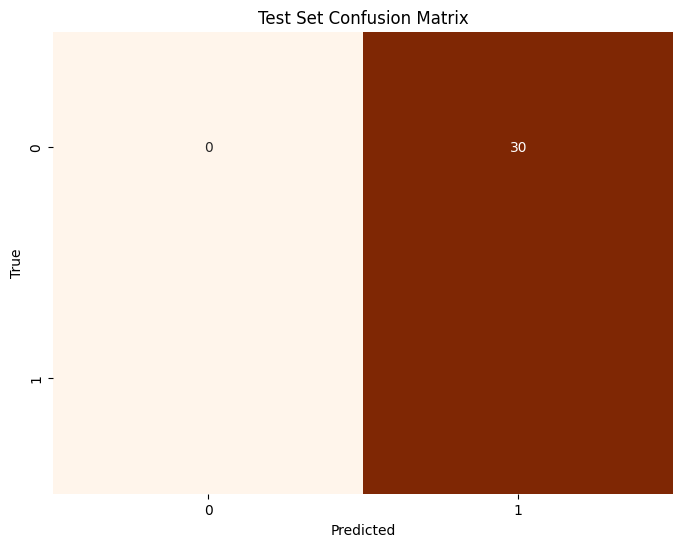

In [22]:
# Plot confusion matrix for the test set

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Oranges', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()